<a href="https://colab.research.google.com/github/wllgrnt/keras-examples/blob/master/Chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8

## Generative Deep Learning


In [1]:
import keras
import numpy as np
import random
import sys
import scipy
import imageio

from IPython.display import Image

Using TensorFlow backend.


## Text Generation with LSTM

Here we use RNNs to generate sequence data, specifically for the case of text data. We train a network to predict the next token, given the previous tokens - then we feed it an initial string of text and let it go. We choose the next character not using greedy sampling (choosing the most likely token) but stochastically - we control the amount of stochasticity using the softmax temperature.

In [0]:
# Reweight a probablity distribution to a different temperature
def reweight_distro(original_distro, temperature=0.5):
  distro = np.log(original_distro) / temperature
  distro = np.exp(distro)
  return distro / np.sum(distro)


### Character-level LSTM text generation

Here we train on Nietzsche.


In [4]:
path = keras.utils.get_file("nietzsche.txt", origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
with open(path) as flines:
  text = flines.read().lower()

print(f"Corpus length: {len(text)}")

Corpus length: 600893


In [6]:
# Extract partially overlapping sequences of length `maxlen`, one-hot encode, and pack them into
# a 3D Numpy array `x` of shape `(sequences, maxlen, unique_characters)`. `y` will contain
# the corresponding targets - the one-hot-encoded next character in each sequence

maxlen = 60
step = 3
sentences = []
next_chars = []

for i in range(0,len(text)-maxlen, step):
  sentences.append(text[i:i+maxlen])
  next_chars.append(text[i+maxlen])
  
print(f"Number of sequences: {len(sentences)}")

chars = sorted(list(set(text)))
print(f"Unique characters: {len(chars)}")
# Dict mapping characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Binary arrays
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i,t,char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57


In [0]:
# The network is a single LSTM layer + a Dense classifier and softmax
# (we could also use 1d convnets)

model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(keras.layers.Dense(len(chars), activation="softmax"))

optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [0]:
# Draw from the model a probability distro for the next character
# Reweight to a given temperature
# Sample the next character
# Add the new character

def sample(preds, temperature=1.0):
  """
  Sample the next character given the model's predictions
  """
  preds = np.asarray(preds).astype("float64")
  preds = np.log(preds)/temperature
  exp_preds = np.exp(preds)
  preds = exp_preds/np.sum(exp_preds)
  probs = np.random.multinomial(1, preds, 1)
  return np.argmax(probs)

In [16]:
for epoch in range(1,20):
  print(f"Epoch {epoch}")
  model.fit(x,y, batch_size=128, epochs=1)
  # Select a text seed at random
  start_index = random.randint(0, len(text) - maxlen - 1)
  generated_text = text[start_index:start_index+maxlen]
  print(f"--- Generating with seed: '{generated_text}'")
  
  for temperature in [0.2, 0.5, 1.0, 1.2]:
    generated_text = text[start_index:start_index+maxlen]
    print(f"------ temperature: {temperature}")
    print(generated_text, end="")
    # Generate 400 characters, starting from the seed text
    for i in range(400):
      sampled = np.zeros((1, maxlen, len(chars)))
      for t, char in enumerate(generated_text):
        sampled[0, t, char_indices[char]] = 1
        
      preds = model.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature)
      next_char = chars[next_index]
      
      generated_text += next_char
      generated_text = generated_text[1:]
      
      print(next_char, end="")
    print()
  print()

Epoch 1
Epoch 1/1
200278/200278 [==============================] - 258s 1ms/step - loss: 1.9971
--- Generating with seed: 's not only a complex of sensation and
thinking, but it is ab'
------ temperature: 0.2
s not only a complex of sensation and
thinking, but it is able the german the servician and the spiritions of the self the self conditions of the self and the spirit and every a develong the stander and the german the stard the german the self and the servitual of the man to the self the serveration of the self has the spirit and the german the self and the german it is the german which the such a start of the self one and the self intility of the self and
------ temperature: 0.5
s not only a complex of sensation and
thinking, but it is able of a mone and the selfitions there are the seaps has as a difficulty and dount and readed and it is to their its inspiritions of a were all preself--what how a everything of the i dears it is the german the spirit and everything their the suns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


ntaim dreverous nature,
ssoled by a even for it, alsedss. by the verience. woman rechological furning "frobest to weaugh,
------ temperature: 1.2
gical ceremony
whereby a demon is constrained to move the boluric firtor realf forms of burdee. fre?che--grayed, the nature, spirity" are
sucefuc. never aamine before mindardskes, woman. long philosophical pared way way, surtys.=-within illiny, begeat as
there is more medeame in the "present tempula,, moyesness? endience.. germans ou) hadd; and awaiti, diolatment to menteal is petes
in ofdennez, andy--he is our bichest and beegest--nesseprors, said, h"-tis

Epoch 9
Epoch 1/1
200278/200278 [==============================] - 261s 1ms/step - loss: 1.4177
--- Generating with seed: 'h we now call
life and experience--is a gradual evolution, i'
------ temperature: 0.2
h we now call
life and experience--is a gradual evolution, in the strength the philosophy the philosophy the strength of the philosophy the strength in the sense of the strength the s

## DeepDream

Here we implement an image-modification technique, similar to the filter-visualisation used to interpet convnets. We do gradient ascent to maximise the activation of entire layers, starting from an existing image (and processing at different scales). We start using a convnet pretrained on ImageNet

In [2]:
keras.backend.set_learning_phase(0)  # disable all training-specific operations

model = keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False)

W0704 12:43:18.450114 140129720133504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 12:43:18.471346 140129720133504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 12:43:18.476210 140129720133504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 12:43:18.499005 140129720133504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0704 12:43:18.500487 140129720

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
# Compute the loss - the quantity we're maximising. Here it's the activation of all filters in a 
# number of layers. The set of layers strongly affects the final viz.
layer_contributions = {
    "mixed2": 0.2,
    "mixed3": 3,
    "mixed4": 2,
    "mixed5": 1.5
}

# The loss is the weighted sum of the L2 norm of the layers' activations
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = keras.backend.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  
  scaling = keras.backend.prod(keras.backend.cast(keras.backend.shape(activation), "float32"))
  # only include non-border artifacts
  loss += coeff * keras.backend.sum(keras.backend.square(activation[:, 2:-2, 2:-2, :]))/scaling
  

W0704 12:43:31.694179 140129720133504 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
# Perform the gradient ascent
dream = model.input

# Compute the gradients of the dream wrt the loss
grads = keras.backend.gradients(loss, dream)[0]

# Normalise the gradients
grads /= keras.backend.maximum(keras.backend.mean(keras.backend.abs(grads)), 1e-7)

# Set up a Keras function to retrieve the loss and gradients, given an input image
outputs = [loss, grads]
fetch_loss_and_grads = keras.backend.function([dream], outputs)

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None, verbose=0):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    if verbose:
      print(f"...Loss value at {i}: {loss_value}")
    x += step*grad_values
  return x

In [5]:
!wget --no-check-certificate \
https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/African_elephant_warning_raised_trunk.jpg/800px-African_elephant_warning_raised_trunk.jpg \
-O /tmp/elephant.jpg


--2019-07-04 12:43:32--  https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/African_elephant_warning_raised_trunk.jpg/800px-African_elephant_warning_raised_trunk.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100679 (98K) [image/jpeg]
Saving to: ‘/tmp/elephant.jpg’

/tmp/elephant.jpg   100%[===================>]  98.32K  --.-KB/s    in 0.03s   

2019-07-04 12:43:33 (3.06 MB/s) - ‘/tmp/elephant.jpg’ saved [100679/100679]



In [0]:
# Auxiliary functions
def resize_img(img, size):
  img = np.copy(img)
  factors = (1,
             float(size[0])/img.shape[1],
             float(size[1])/img.shape[2],
             1)
  return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
  pil_img = deprocess_image(np.copy(img))
  imageio.imwrite(fname, pil_img)
  
def preprocess_image(image_path):
  img = keras.preprocessing.image.load_img(image_path)
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

def deprocess_image(x):
  if keras.backend.image_data_format() == "channels_first":
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1,2,0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2
  x += 0.5
  x *= 255.
  x = np.clip(x, 0, 255).astype("uint8")
  return x


In [13]:
# We perform the DeepDream algorithm by defining a list of scales - each scale is larger than the 
# next - we process a small image then scale it up. To avoid losing detail after scaling we 
# reinject the lost details back into the image

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10

base_image_path = "/tmp/elephant.jpg"
img = preprocess_image(base_image_path)

# Prepare a list of shape tuples defining the scales at which to run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim/(octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
  
# Put the shapes in increasing oder
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print(f"Processing image shape {shape}")
  img = resize_img(img, shape)
  img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname=f"/tmp/dream_at_scale_{shape}.png")
  
save_img(img, fname="/tmp/final_dream.png")
  
  

Processing image shape (271, 408)
Processing image shape (380, 571)
Processing image shape (533, 800)


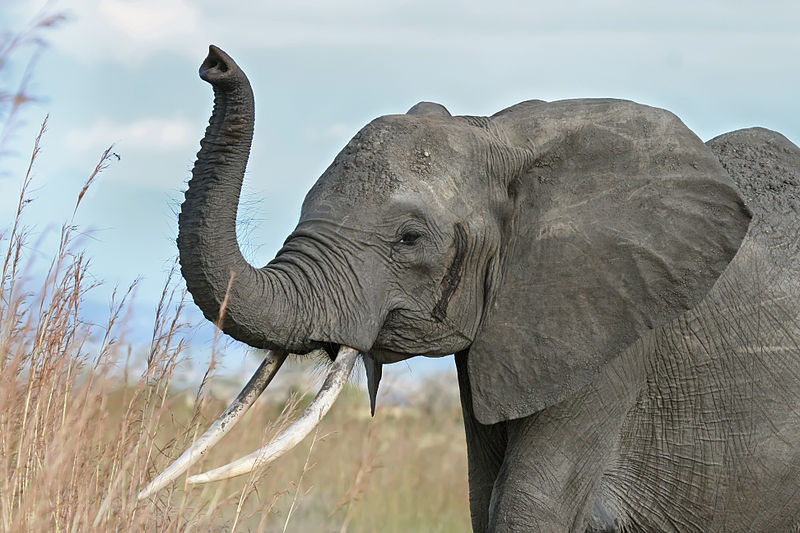

In [14]:
Image("/tmp/elephant.jpg")

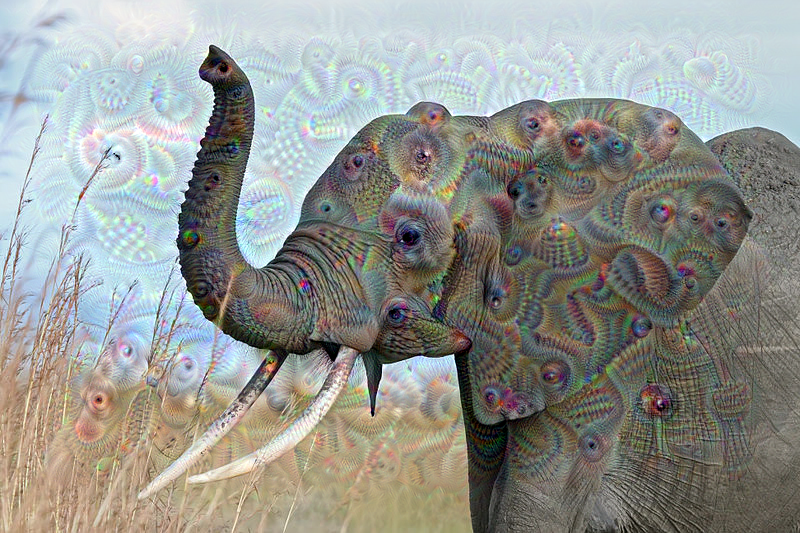

In [15]:
Image("/tmp/final_dream.png")

W0704 12:43:55.135304 140129720133504 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


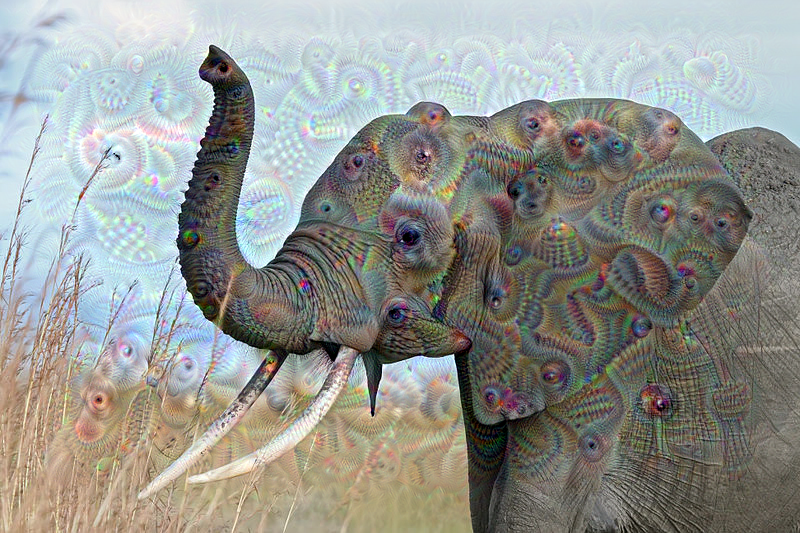

In [8]:
# We perform the DeepDream algorithm by defining a list of scales - each scale is larger than the 
# next - we process a small image then scale it up. To avoid losing detail after scaling we 
# reinject the lost details back into the image
def deepDream(image_path, step, num_octave,
              octave_scale, iterations, layer_contributions, max_loss, verbose=0):
  """
  Wrap the deepDream algo in a function, to mess about with hyperparams.
  """
 
  # The loss is the weighted sum of the L2 norm of the layers' activations
  layer_dict = dict([(layer.name, layer) for layer in model.layers])

  
  
  loss = keras.backend.variable(0.)
  for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = keras.backend.prod(keras.backend.cast(keras.backend.shape(activation), "float32"))
    # only include non-border artifacts
    loss += coeff * keras.backend.sum(keras.backend.square(activation[:, 2:-2, 2:-2, :]))/scaling
  
  # Perform the gradient ascent
  dream = model.input

  # Compute the gradients of the dream wrt the loss
  grads = keras.backend.gradients(loss, dream)[0]

  # Normalise the gradients
  grads /= keras.backend.maximum(keras.backend.mean(keras.backend.abs(grads)), 1e-7)

  # Set up a Keras function to retrieve the loss and gradients, given an input image
  outputs = [loss, grads]
  fetch_loss_and_grads = keras.backend.function([dream], outputs)
  
  
  img = preprocess_image(image_path)

  # Prepare a list of shape tuples defining the scales at which to run gradient ascent
  original_shape = img.shape[1:3]
  successive_shapes = [original_shape]
  for i in range(1, num_octave):
    shape = tuple([int(dim/(octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

  # Put the shapes in increasing oder
  successive_shapes = successive_shapes[::-1]

  original_img = np.copy(img)
  shrunk_original_img = resize_img(img, successive_shapes[0])

  for shape in successive_shapes:
    if verbose:
      print(f"Processing image shape {shape}")
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss, verbose=verbose)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
#     save_img(img, fname=f"/tmp/dream_at_scale_{shape}.png")

  save_img(img, fname="/tmp/final_dream_tmp.png")
  return Image("/tmp/final_dream_tmp.png")
  

params = {"step": 0.01,
          "num_octave": 3,
          "octave_scale": 1.4,
          "iterations": 20,
          "max_loss": 10,
          "image_path": "/tmp/elephant.jpg",
          "layer_contributions": layer_contributions
         }
deepDream(**params) 

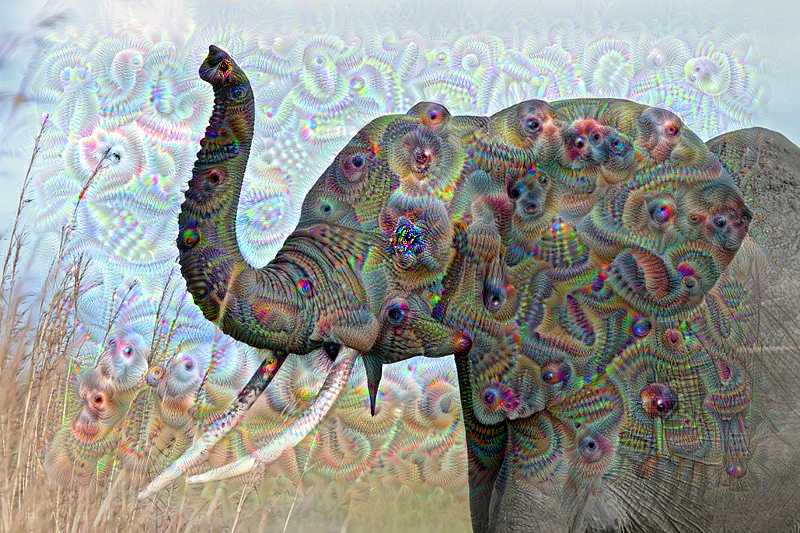

In [9]:
params = {"step": 0.01,
          "num_octave": 3,
          "octave_scale": 1.4,
          "iterations": 20,
          "max_loss": 50, 
          "image_path": "/tmp/elephant.jpg",
          "layer_contributions": layer_contributions
         }
deepDream(**params) 

In [0]:
layer_contributions = {
    "mixed7": 0.2,
    "mixed8": 3,
    "mixed9": 2,
    "mixed10": 1.5
}
params = {"step": 0.01,
          "num_octave": 10,
          "octave_scale": 1.4,
          "iterations": 20,
          "max_loss": 10, 
          "image_path": "/tmp/elephant.jpg",
          "layer_contributions": layer_contributions
         }
deepDream(**params) 

## Neural style transfer 